In [1]:
import pandas as pd
import uproot
import numpy as np
import cmath
import matplotlib.pyplot as plt
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
infile = uproot.open('dataset_bin_8.root')['DecayTree'].arrays(library = 'pd')

FileNotFoundError: [Errno 2] No such file or directory: '/home/hep/mesmith/private/flavio_messing/dataset_bin_8.root'

In [258]:
infile['moment_FL'] = 2. - 2.5*(1. - infile['ctk']**2)
infile['moment_S3'] = 3.125*(1. - infile['ctk']**2)*(1. - infile['ctl']**2)*np.cos(2.*infile['phi'])
infile['moment_S5'] = 2.5 * np.sqrt(1. - infile['ctl']*infile['ctl']) * 2 * infile['ctk'] * np.sqrt(1. - infile['ctk']*infile['ctk']) * np.cos(infile['phi'])
infile['moment_S4'] = 3.125*2*infile['ctl'] * np.sqrt(1. - infile['ctl']*infile['ctl']) * 2 * infile['ctk'] * np.sqrt(1. - infile['ctk']*infile['ctk']) * np.cos(infile['phi'])
infile['moment_AFB'] = 0.75*2.5*(1. - infile['ctk']**2)*infile['ctl']
infile['moment_S7'] = 2.5*2 * infile['ctk'] * np.sqrt(1. - infile['ctk']*infile['ctk'])*np.sqrt(1. - infile['ctl']*infile['ctl'])*np.sin(infile['phi'])
infile['moment_S8'] = 3.125*2 * infile['ctk'] * np.sqrt(1. - infile['ctk']*infile['ctk'])*2.*infile['ctl']*np.sqrt(1. - infile['ctl']*infile['ctl'])*np.sin(infile['phi'])
infile['moment_S9'] = 3.125*(1. - infile['ctk']**2)*(1. - infile['ctl']**2)*np.sin(2.*infile['phi'])
print(len(infile['moment_S5']))

109566


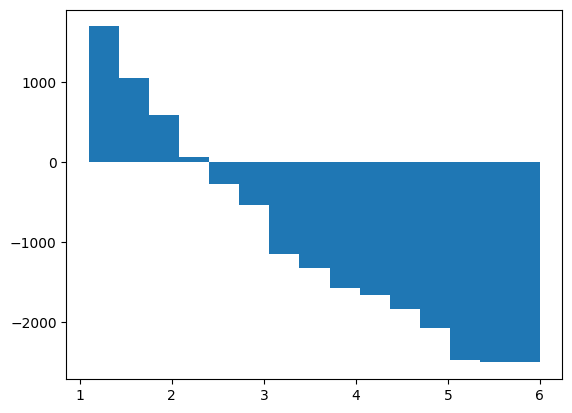

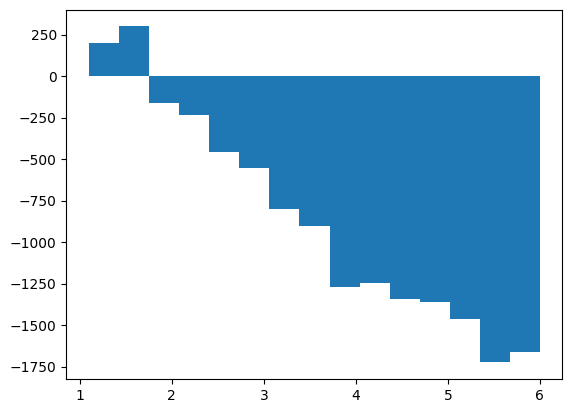

In [259]:
plt.figure()
mom_bins5 = plt.hist(infile['q2'], weights = infile['moment_5'], bins = 15)
plt.figure()
mom_bins4 = plt.hist(infile['q2'], weights = infile['moment_4'], bins = 15)

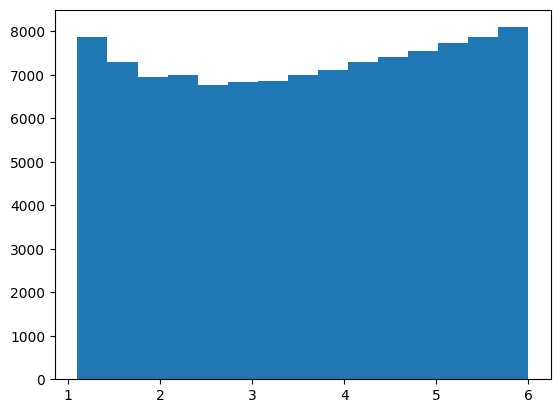

In [186]:
plt.figure()
r_bins = plt.hist(infile['q2'], bins = 15)

In [187]:
mom_bins5[1]

array([1.10003573, 1.42669864, 1.75336154, 2.08002445, 2.40668736,
       2.73335026, 3.06001317, 3.38667608, 3.71333898, 4.04000189,
       4.3666648 , 4.6933277 , 5.01999061, 5.34665352, 5.67331642,
       5.99997933])

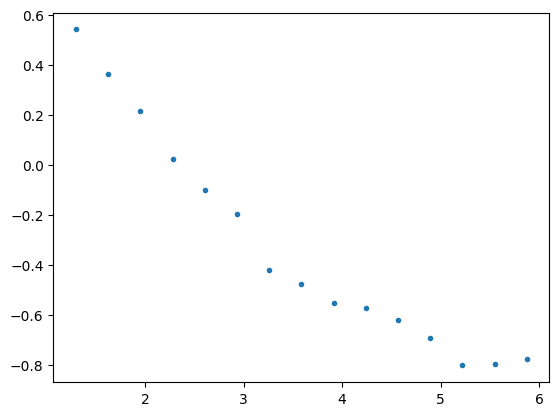

In [188]:
plt.figure()
plt.plot(mom_bins5[1][0:15]+0.2, (5/2) * mom_bins5[0]/r_bins[0], '.')

In [189]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF
from sklearn import neighbors
from scipy.ndimage.filters import gaussian_filter1d
from scipy.interpolate import interp1d 

In [190]:
#kernel = DotProduct() + WhiteKernel()
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

In [253]:
knn = neighbors.KNeighborsRegressor(500, weights="uniform")
#gpr = GaussianProcessRegressor(kernel=kernel,
#         random_state=0).fit(np.array(infile['q2'][:1000]).reshape(1000,1), infile['moment_5'][:1000])


In [261]:
#mean_prediction, std_prediction = gpr.predict(np.array(infile['q2'][:1000]).reshape(1000,1), return_std=True)
T = np.linspace(1.1,6.0,10000)[:, np.newaxis]
unbins = {}
for _s in range(200):
    unbins[_s] = {}
    tsample = infile.sample(20000)
    for _obs in ['FL', 'S3', 'S4', 'S5', 'AFB', 'S7', 'S8', 'S9']:
        unbins[_s][_obs] = knn.fit(np.array(tsample['q2']).reshape(20000,1), tsample['moment_%s' % _obs][:20000]).predict(T)

8


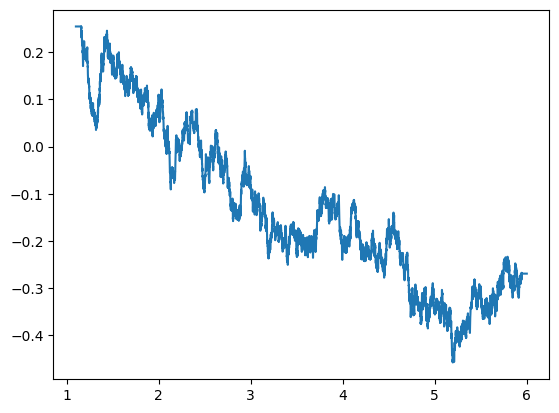

In [262]:
plt.figure()
plt.plot(T, unbins[0]['S5'])
print(len(unbins[0]))

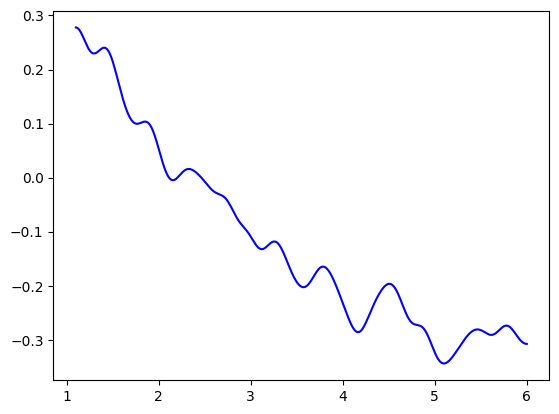

In [263]:
plt.plot(T, gaussian_filter1d(unbins[80]['S5'], sigma=200), color='b')

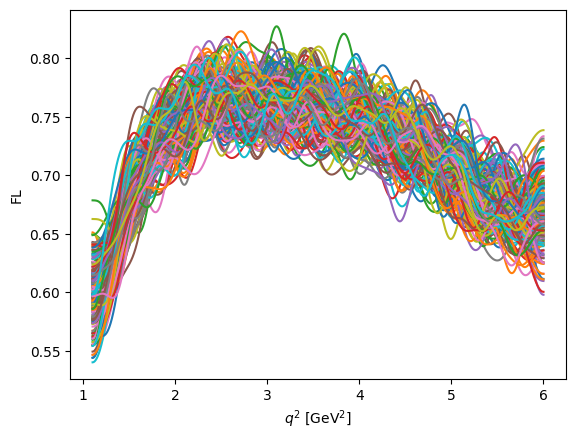

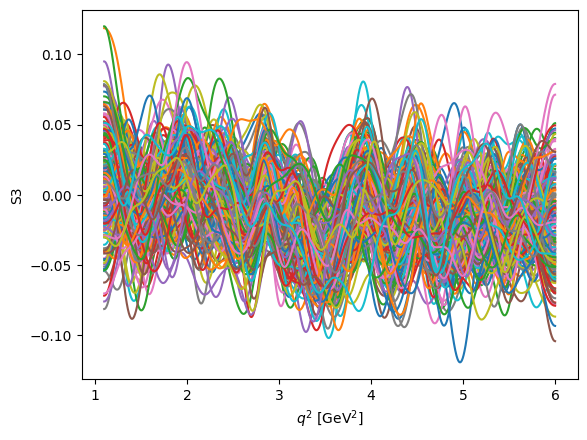

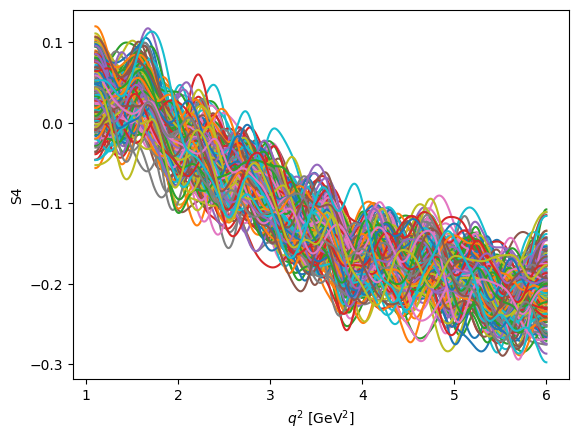

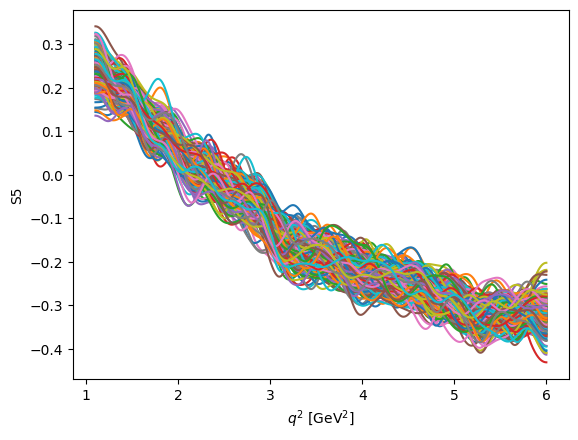

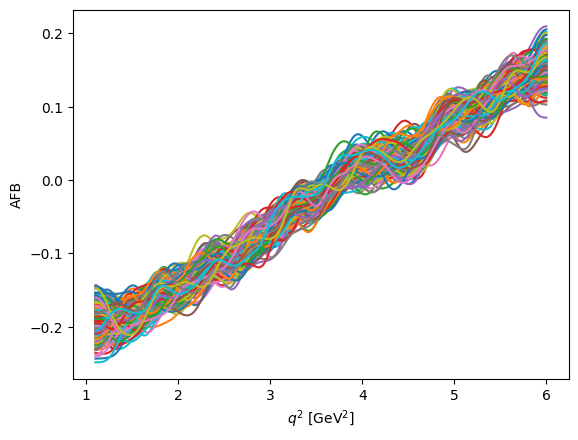

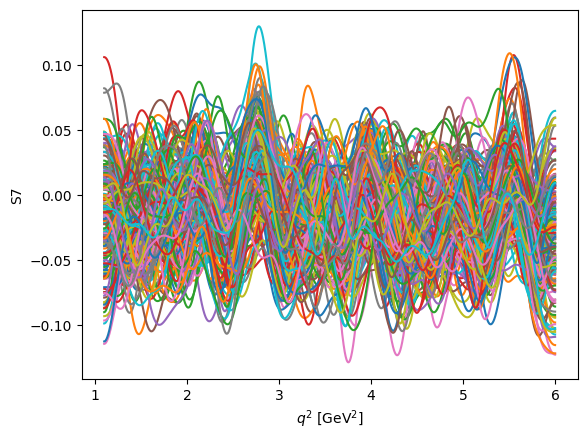

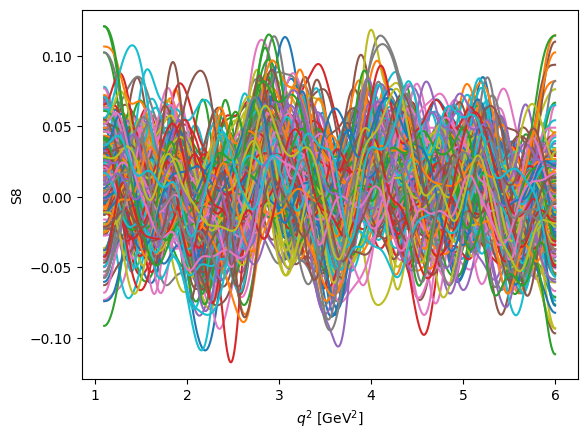

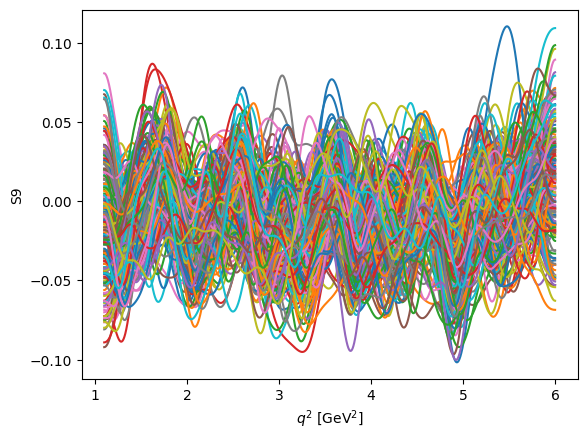

In [264]:
filtered_unbins = {}
plt.figure()
for _obs in ['FL', 'S3', 'S4', 'S5', 'AFB', 'S7', 'S8', 'S9']:
    filtered_unbins[_obs] = {}
    for _s in range(200):
        filtered_unbins[_obs][_s] = gaussian_filter1d(unbins[_s][_obs], sigma=200)
        plt.plot(T, filtered_unbins[_obs][_s])
    plt.ylabel(_obs)
    plt.xlabel('$q^{2}$ [GeV$^{2}$]')
    plt.show()

In [265]:
mean_vals = {}
lower_vals = {}
upper_vals = {}
sigma_vals = {}
for _obs in ['FL', 'S3', 'S4', 'S5', 'AFB', 'S7', 'S8', 'S9']:
    mean_vals[_obs] = []
    lower_vals[_obs] = []
    upper_vals[_obs] = []
    sigma_vals[_obs] = []
for _v in range(10000):
    for _obs in ['FL', 'S3', 'S4', 'S5', 'AFB', 'S7', 'S8', 'S9']:
        ordered = [filtered_unbins[_obs][_s][_v] for _s in range(200)]
        ordered.sort()
        mean_vals[_obs].append(np.mean(ordered))
        lower_vals[_obs].append(ordered[32])
        upper_vals[_obs].append(ordered[168])
        sigma_vals[_obs].append(0.5*abs(upper_vals[_obs][-1] - lower_vals[_obs][-1]))

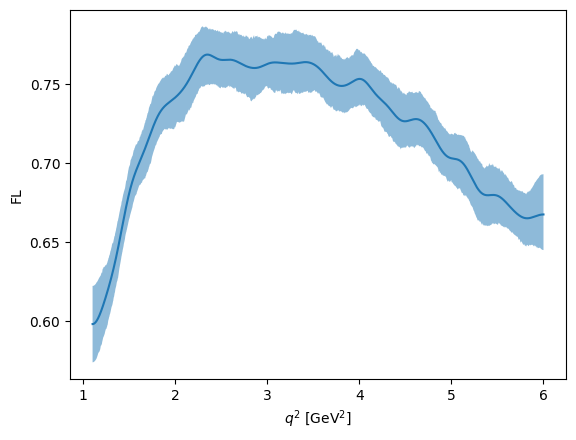

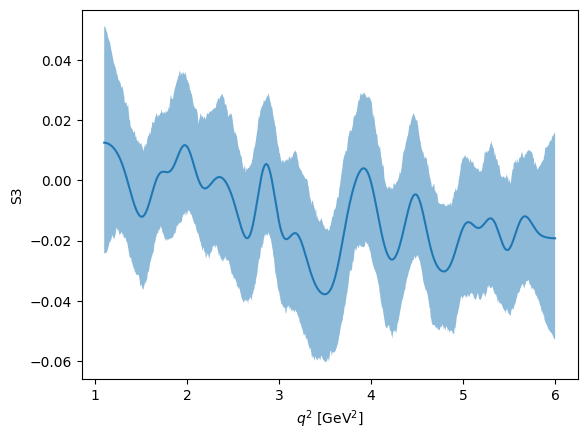

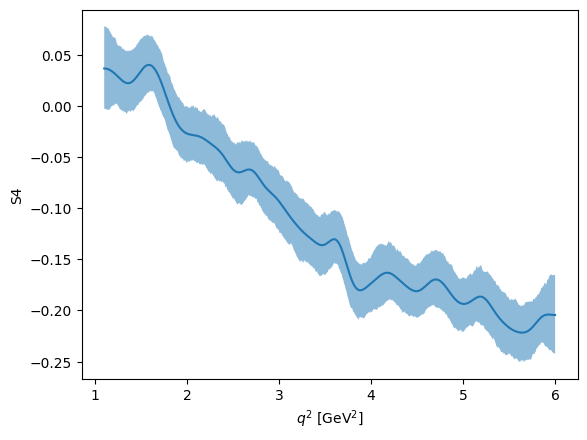

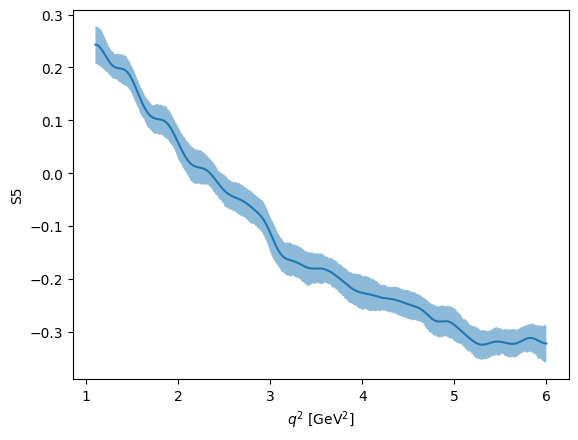

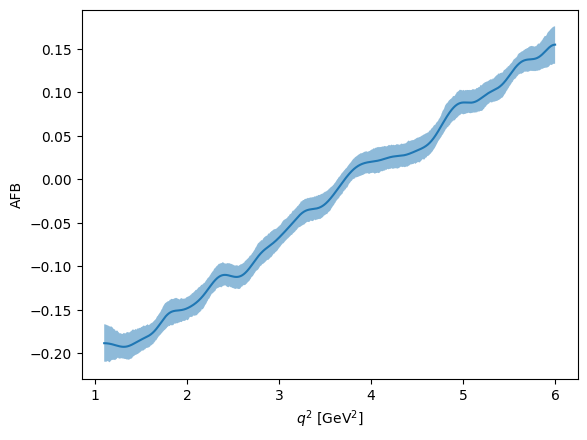

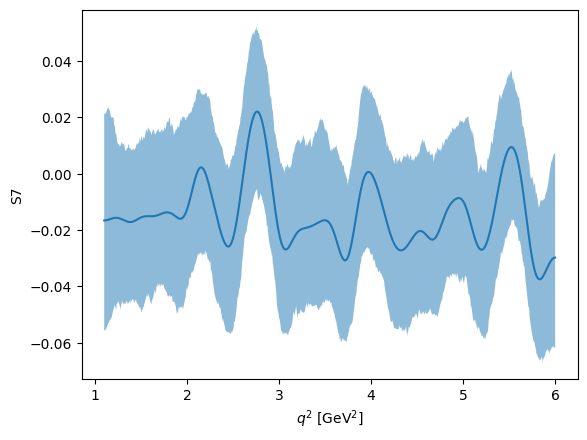

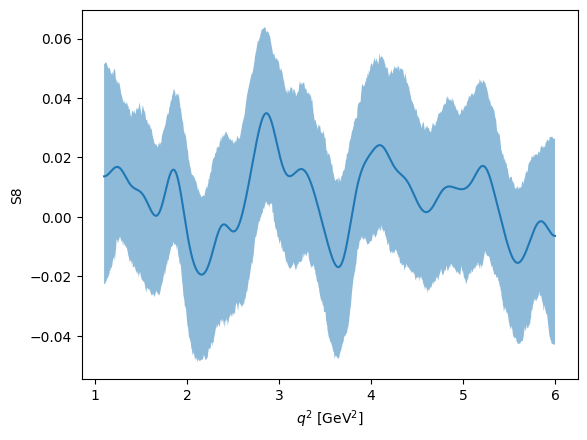

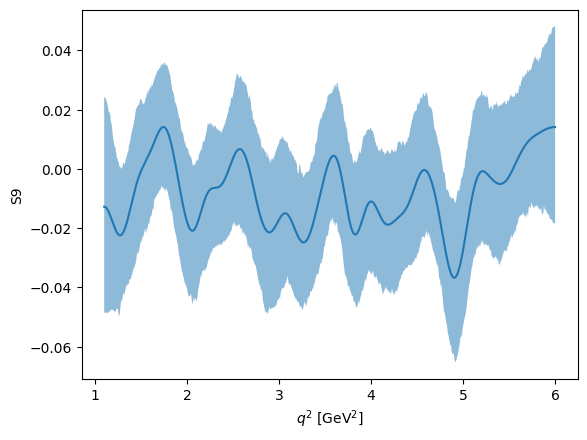

In [267]:
for _obs in ['FL', 'S3', 'S4', 'S5', 'AFB', 'S7', 'S8', 'S9']:
    plt.figure()
    plt.plot(T, mean_vals[_obs])
    plt.fill_between(T.reshape(10000), lower_vals[_obs], upper_vals[_obs], alpha = 0.5)
    plt.ylabel(_obs)
    plt.xlabel('$q^{2}$ [GeV$^{2}$]')

In [268]:
from sklearn.neighbors import BallTree

In [269]:
 tree = BallTree(np.array(tsample['q2']).reshape(20000,1), leaf_size=2)

In [274]:
dist, ind = tree.query([[1.211]], k=400)

In [276]:
def moment5_var(indices, moment):
    rs = infile.loc[indices[0]]
    angles = 0.4 * moment - np.sqrt(1. - rs['ctl']*rs['ctl']) * 2 * rs['ctk'] * np.sqrt(1. - rs['ctk']*rs['ctk']) * np.cos(rs['phi'])
    tsum = np.sum(angles**2)
    return 2.5*np.sqrt((1./(299.*300.))*tsum)

In [277]:
moms5_var = moment5_var(ind, 0.)

In [278]:
moms5_var

0.08115571369663305

In [280]:
tvars = []
_i = 0
for _q2 in T.reshape(10000):
    _, ind = tree.query([[_q2]], k=400)
    tvars.append(0.5*moment5_var(ind, mean_vals['S5'][_i]))
    _i+=1

In [281]:
current_S5 = [6.9419e-9/6.17831e-8, -9.46732e-9/6.29868e-8, -2.94643e-8/9.41826e-8]
current_S5_err = [0.0373, 0.0438, 0.03102]
current_q2_centre = [1.8, 3.25, 5.0]
current_q2_width = [0.7, 0.75, 1.0]

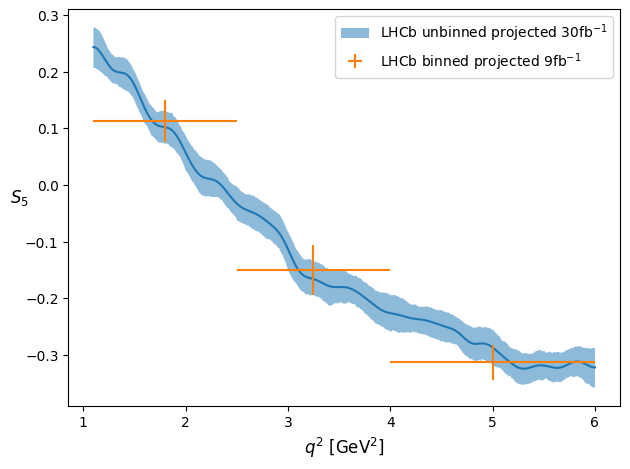

In [282]:
plt.figure()
plt.plot(T, mean_vals['S5'])
#plt.fill_between(T.reshape(10000), np.subtract(mean_vals,tvars), np.add(mean_vals, tvars), alpha = 0.5, label = 'LHCb unbinned projected 30fb$^{-1}$')
plt.fill_between(T.reshape(10000), lower_vals['S5'], upper_vals['S5'], alpha = 0.5, label = 'LHCb unbinned projected 30fb$^{-1}$')
plt.errorbar(current_q2_centre, current_S5, yerr = current_S5_err, xerr = current_q2_width, label = 'LHCb binned projected 9fb$^{-1}$', linestyle = '')
plt.ylabel('$S_{5}$', fontsize = 'large', rotation = 0)
plt.xlabel('$q^{2}$ [GeV$^{2}$]', fontsize = 'large')
plt.legend()
plt.tight_layout()
plt.savefig('unbinned_S5.png')

In [283]:
mean_vals

{'FL': [0.5980049660890836,
  0.5980054812090061,
  0.5980065114736159,
  0.5980080562798797,
  0.598010116133432,
  0.5980126905732354,
  0.5980157799640078,
  0.5980193841934626,
  0.5980235027607066,
  0.598028135861734,
  0.5980332832858578,
  0.5980389449117091,
  0.5980451206148539,
  0.5980518098120104,
  0.5980590119844948,
  0.5980667268552466,
  0.598074953843438,
  0.5980836927539986,
  0.5980929433565974,
  0.5981027049822318,
  0.5981129773057992,
  0.5981237599331175,
  0.5981350523757213,
  0.5981468542314472,
  0.5981591650128947,
  0.5981719843757409,
  0.5981853115811944,
  0.5981991461416797,
  0.5982134874408884,
  0.5982283349068596,
  0.5982436874097394,
  0.5982595443189908,
  0.5982759052011403,
  0.5982927695176554,
  0.5983101363779032,
  0.5983280047995356,
  0.5983463741383502,
  0.5983652437378435,
  0.5983846127254625,
  0.5984044803711265,
  0.5984248455914402,
  0.5984457083377357,
  0.598467067314841,
  0.5984889213142773,
  0.5985112695829753,
  0.5985

In [285]:
sigma_vals['S5']

[0.035825347458089254,
 0.035824734889941465,
 0.03582351538116903,
 0.03582168091003511,
 0.03581923089723078,
 0.035816168607010854,
 0.03581249247754163,
 0.03580820064011149,
 0.03580329758108004,
 0.03579778641327079,
 0.03579166670606061,
 0.035784933947941314,
 0.03577758784530119,
 0.03576963615312602,
 0.03576107637506336,
 0.0357519110610182,
 0.03574213828255228,
 0.03573569164028005,
 0.03573178415993676,
 0.03572766463193523,
 0.0357233214095284,
 0.035718764572231596,
 0.035713993112180306,
 0.035709004032840316,
 0.03570379716715545,
 0.03569837796579024,
 0.03569274086995751,
 0.035686894473653016,
 0.03568083077979352,
 0.035674559387909324,
 0.03566807569784959,
 0.03566138011863003,
 0.03565447428545444,
 0.03564735916882443,
 0.03564002932046127,
 0.03563336538003421,
 0.035631355866844794,
 0.03562929122358964,
 0.035627173421989,
 0.03560530590013253,
 0.03557059920002113,
 0.03553504619972388,
 0.0354986530682615,
 0.03546142186089876,
 0.03542334721181961,
 0.03

In [286]:
import json
with open('means.json', 'w') as fp:
    json.dump(mean_vals, fp)
with open('sigmas.json', 'w') as fp:
    json.dump(sigma_vals, fp)